## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

Running in Colab.
fatal: destination path 'mae' already exists and is not an empty directory.


In [2]:
# Locate the file
file_path = './mae/util/pos_embed.py'

# Read and update the file
with open(file_path, 'r') as file:
    content = file.read()

# Replace 'np.float' with 'float'
updated_content = content.replace('np.float', 'float')
updated_content = updated_content.replace('float32','float')

# Write the updated content back to the file
with open(file_path, 'w') as file:
    file.write(updated_content)

print("Updated 'pos_embed.py' successfully!")

Updated 'pos_embed.py' successfully!


In [3]:
import importlib
import mae.util.pos_embed
importlib.reload(mae.util.pos_embed)

<module 'mae.util.pos_embed' from '/content/mae/util/pos_embed.py'>

### Define utils

In [4]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Utility to load an image

In [5]:
def preprocess_image(img_url, imagenet_mean, imagenet_std, show=False):
  img = Image.open(requests.get(img_url, stream=True).raw)
  img = img.resize((224, 224))
  img = np.array(img) / 255.0
  assert img.shape == (224, 224, 3), f"Unexpected shape: {img.shape}"
  img = (img - imagenet_mean) / imagenet_std
  if show:
      plt.rcParams['figure.figsize'] = [5, 5]
      plt.imshow((img - img.min()) / (img.max() - img.min()))  # Scale to [0, 1] for visualization
      plt.axis('off')
      plt.show()

  return torch.tensor(img)

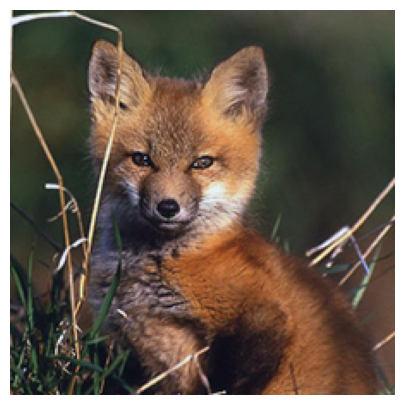

In [6]:
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg'
img = preprocess_image(img_url, imagenet_mean, imagenet_std, show=True)

### Load pre-trained MAE models

Download checkpoints

In [7]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)
# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth


# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)
# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth


# This is an MAE model trained with normalized pixels better suited for downstream finetuning
# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/pretrain/mae_pretrain_vit_large_full.pth

File ‘mae_visualize_vit_large.pth’ already there; not retrieving.

File ‘mae_visualize_vit_large_ganloss.pth’ already there; not retrieving.

File ‘mae_pretrain_vit_large_full.pth’ already there; not retrieving.



Load Required Models

In [8]:
chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')

chkpt_dir = 'mae_pretrain_vit_large_full.pth'
model_mae_norm = prepare_model(chkpt_dir, 'mae_vit_large_patch16')

print('Required Models loaded.')

<ipython-input-4-7b75050b83ad>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, map_location='cpu')


<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
Required Models loaded.


### Run MAE on the images

Utility to process and visualize multiple images

In [9]:
def process_and_visualize_multiple_images(img_urls, model, imagenet_mean, imagenet_std):
  torch.manual_seed(2)
  num_images = len(img_urls)
  plt.rcParams['figure.figsize'] = [24, 6 * num_images]

  for i, img_url in enumerate(img_urls):
    img = preprocess_image(img_url, imagenet_mean, imagenet_std)

    # Convert image to tensor and make it batch-like
    x = torch.tensor(img)
    x = x.unsqueeze(dim=0)  # Add batch dimension: [H, W, C] -> [N, H, W, C]
    x = torch.einsum('nhwc->nchw', x)  # Change to [N, C, H, W]

    # Run the MAE model
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)  # Unpatchify reconstruction
    y = torch.einsum('nchw->nhwc', y).detach().cpu()  # [N, C, H, W] -> [N, H, W, C]

    # Process the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 * 3)  # [N, H*W, p*p*3]
    mask = model.unpatchify(mask)  # Map the mask back to image space
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()  # [N, C, H, W] -> [N, H, W, C]

    # Convert input to [N, H, W, C] for visualization
    x = torch.einsum('nchw->nhwc', x)

    # Masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction combined with visible patches
    im_paste = x * (1 - mask) + y * mask

    # Visualization for this image (4 columns per row)
    plt.subplot(num_images, 4, i * 4 + 1)
    show_image(x[0], "Original")

    plt.subplot(num_images, 4, i * 4 + 2)
    show_image(im_masked[0], "Masked")

    plt.subplot(num_images, 4, i * 4 + 3)
    show_image(y[0], "Reconstruction")

    plt.subplot(num_images, 4, i * 4 + 4)
    show_image(im_paste[0], "Reconstruction + Visible")

  # Display all rows
  plt.show()



MAE with pixel reconstruction:


<ipython-input-9-d8060e9498c1>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(img)


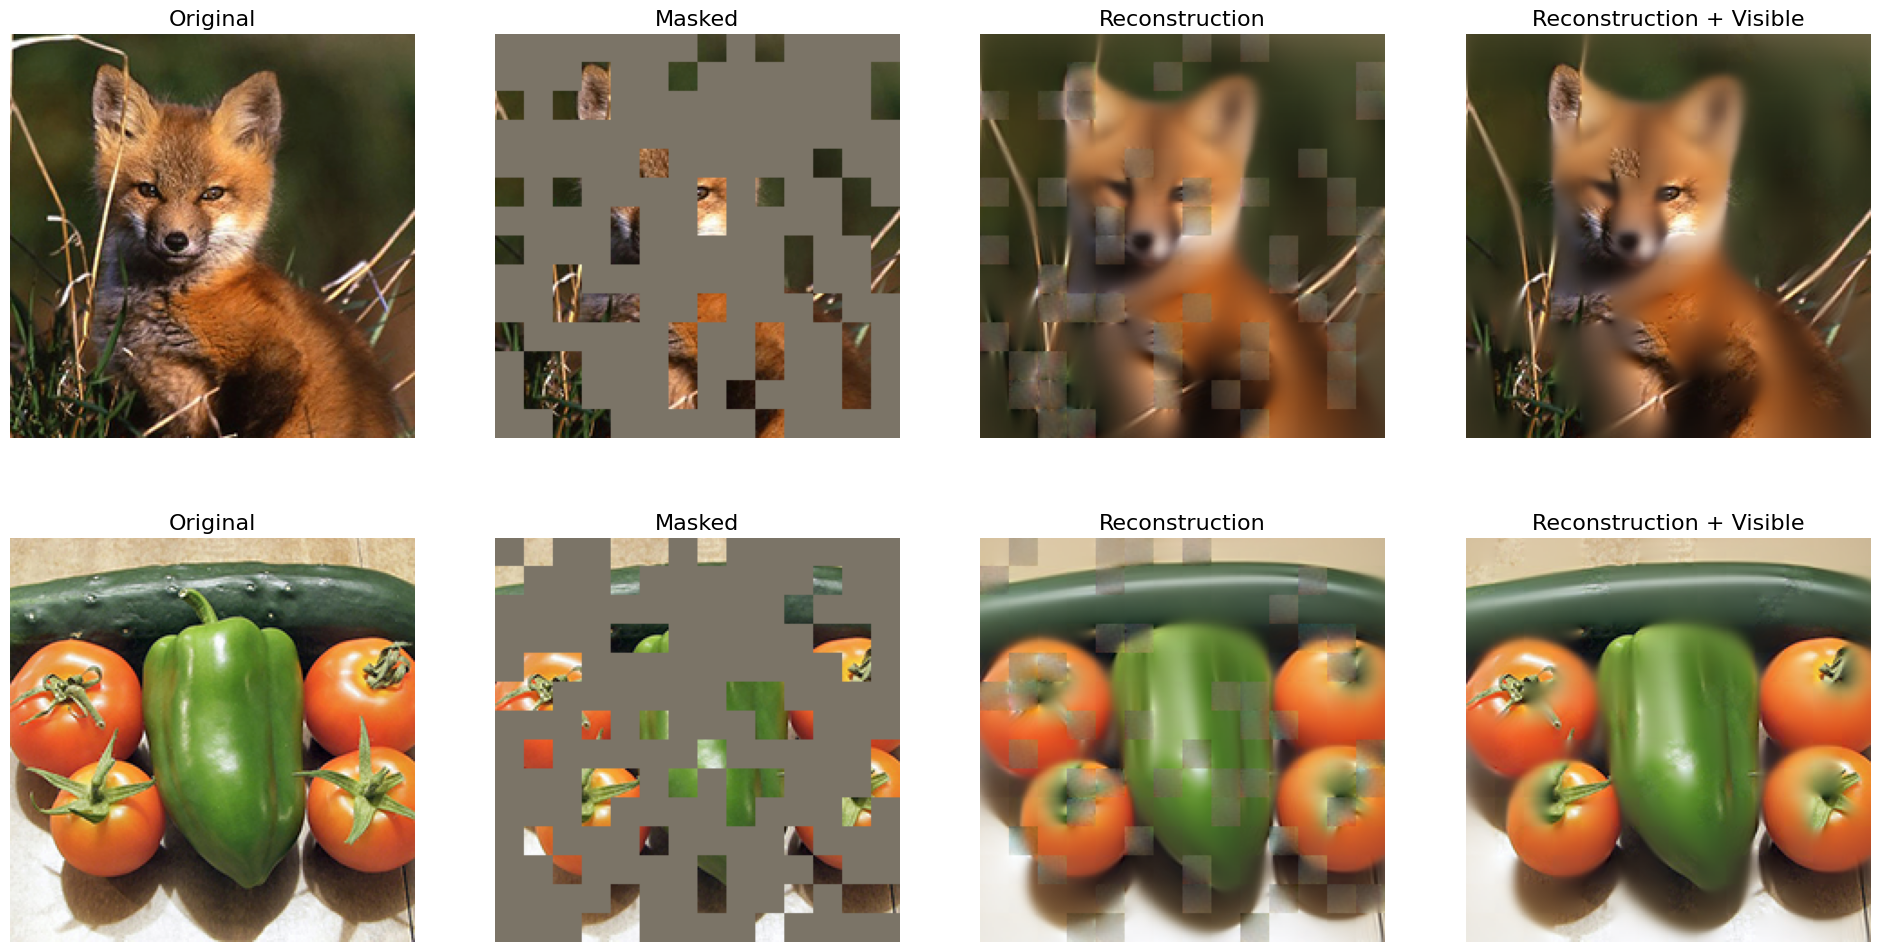

In [10]:
print('MAE with pixel reconstruction:')

img_urls = [
    'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg',  # Fox
    'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg',  # Cucumber
]

# Visualize the images
process_and_visualize_multiple_images(img_urls, model_mae, imagenet_mean, imagenet_std)

### Visualization with multiple images on model trained with additional GAN loss

MAE with pixel reconstruction:


<ipython-input-9-d8060e9498c1>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(img)


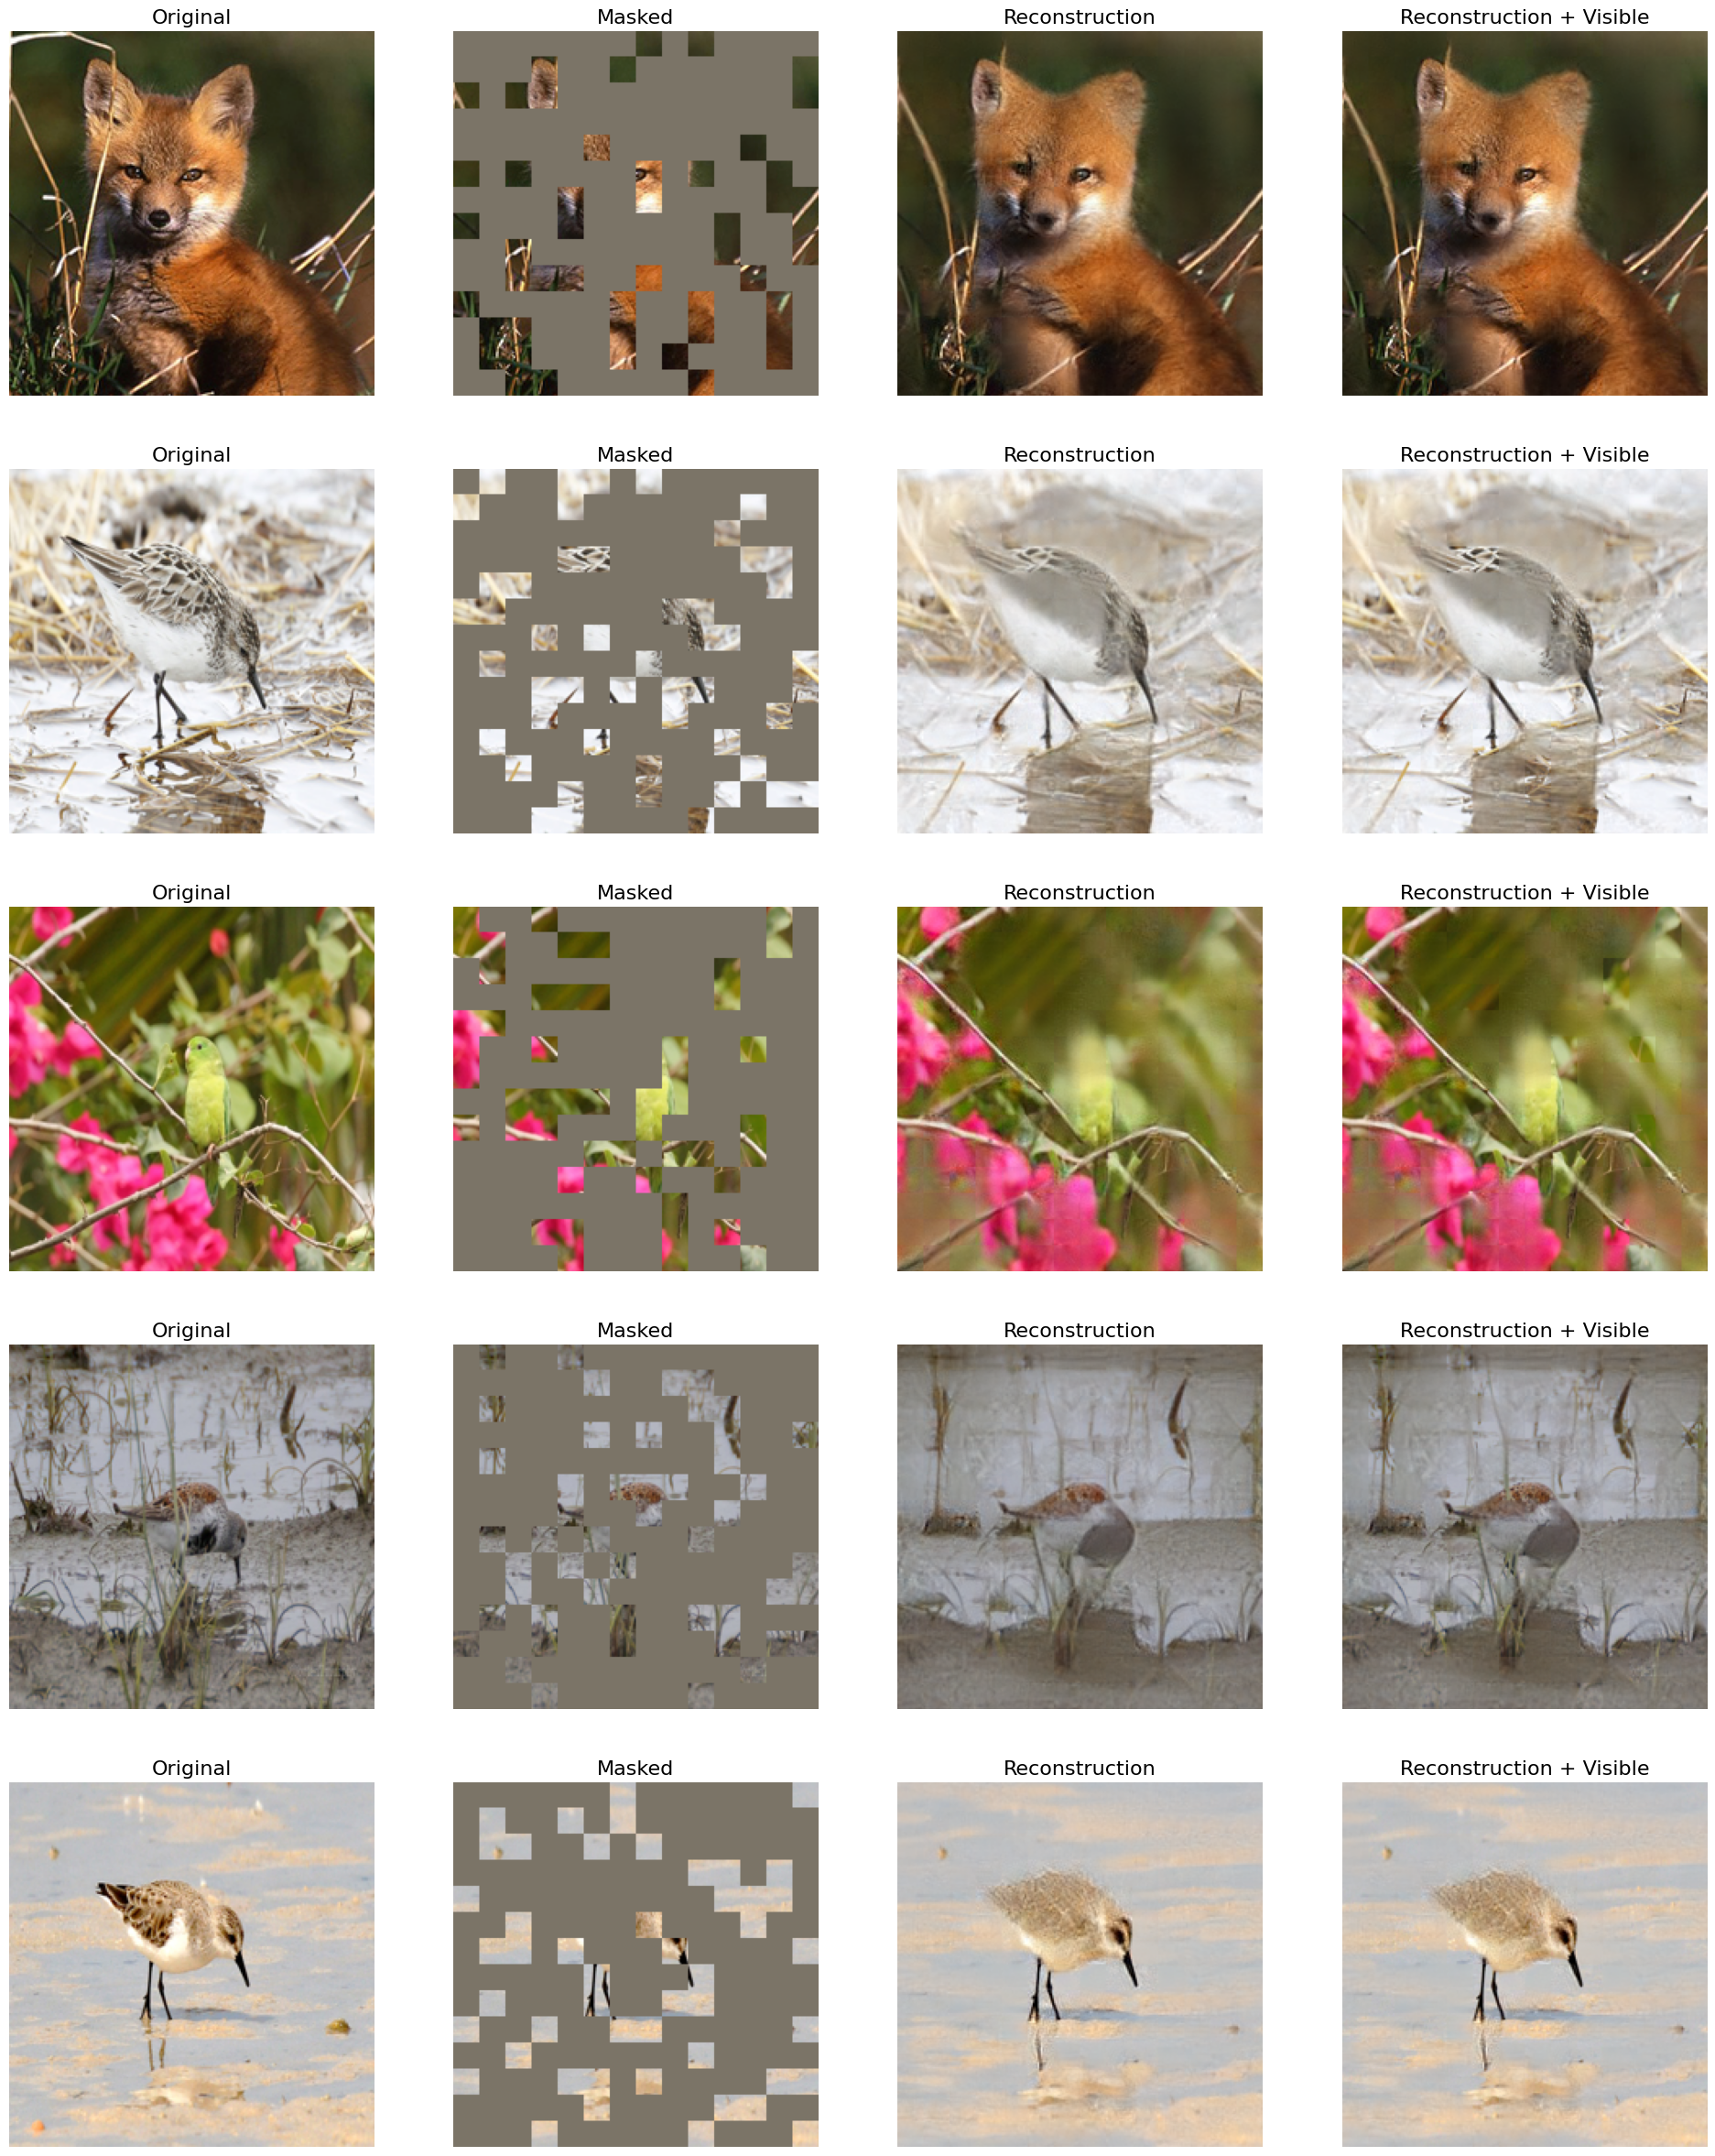

In [11]:
print('MAE with pixel reconstruction:')

img_urls = [
    'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg',  # Fox
    'https://www.dropbox.com/scl/fi/ixnxzswn2wbf4ninv7otv/5.jpg?rlkey=8jntsdko20qptp51d9dpyahmv&raw=1', # Bird 1
    'https://www.dropbox.com/scl/fi/yhuvu2k29y2oker0pkk6l/1662.jpg?rlkey=5nncuwnbjg4wef694cg7g810d&raw=1', # Bird 2
    'https://www.dropbox.com/scl/fi/lx6ky033b9vdzunejnfu6/7371.jpg?rlkey=p7zyvw4dor2oatwdd6gakpi6l&raw=1', # Bird 3
    'https://www.dropbox.com/scl/fi/fvruyppojf9jrk76vgu7l/443.jpg?rlkey=38q3ulq5e8u1w9iio24f30jpa&raw=1' # Bird 4
]

# Visualize the images
process_and_visualize_multiple_images(img_urls, model_mae_gan, imagenet_mean, imagenet_std)

I think since semi aves images involve fine grained details, the reconstruction is still not good enough. But I hope it will improve when we train on semi-aves.

# Running pretrained model with normalized pixels.
This is an MAE model trained with normalized pixels as targets for downstream finetuning. So we should see the blurry reconstruction.

MAE with pixel reconstruction:


<ipython-input-9-d8060e9498c1>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(img)


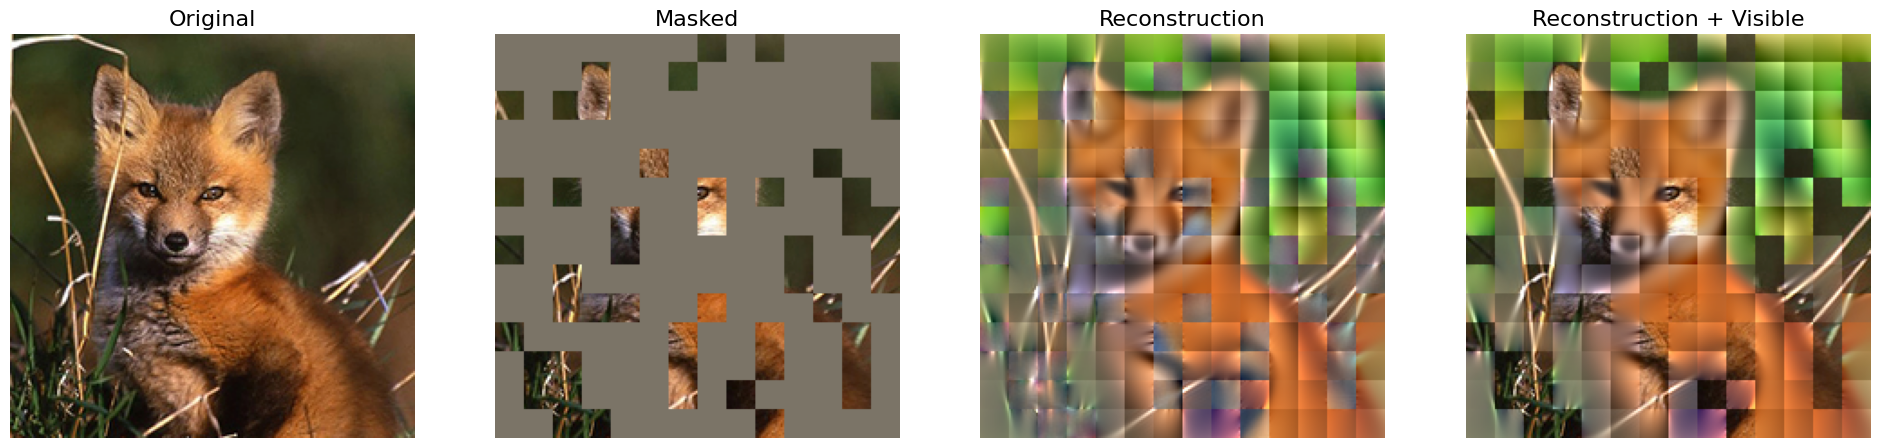

In [12]:
print('MAE with pixel reconstruction:')

img_urls = [
    'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg',  # Fox
]

# Visualize the images
process_and_visualize_multiple_images(img_urls, model_mae_norm, imagenet_mean, imagenet_std)